In [18]:
import os
import glob

import pandas as pd
import pytz
import datetime as dt
import math
import seaborn as sns
import matplotlib as mpl
#mpl.rcParams['path.simplify'] = False
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [19]:

# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

In [20]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals


def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp


def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df


def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df


def mean_std_col_df (df, col_name):
    
    col_list = df[col_name].to_list()
    
    cols_list_float = [float(val) for val in col_list]
    
    cols_list_float_np =np.array(cols_list_float)
    
    mean_col= np.mean(cols_list_float_np)
    std_col = np.std(cols_list_float_np)
    
    return mean_col, std_col


def plot_mean_std(mean_list, std_list, label_list, title_figure, y_label_fig):
    x_pos = np.arange(len(label_list))
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_list, yerr=std_list, align='center', alpha=0.5, capsize=10 )
    ax.set_ylabel(y_label_fig)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(label_list, rotation=45, ha='right', rotation_mode='anchor')
    #title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD"
    ax.set_title(title_figure)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()
    return fig
    
    
def print_start_end_time(timestamp_col):
    
    time_stamp_list = timestamp_col.values
    start_timestamp = time_stamp_list[0]
    last_timestamp  = time_stamp_list[-1]
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    
    start_time = dt.datetime.fromtimestamp(start_timestamp, tz)
    end_time  = dt.datetime.fromtimestamp(last_timestamp, tz)
    
    print("start time:" + str(start_time))
    print("end time:" + str(end_time))
    
    
    

def get_mean_std_event_list(psychopy_df, shimmer_df_selected, event_interest_list_new, offset_min_list_new, timestamp_sensor_col_name, data_col_name):

    mean_cumm_list = []
    std_cumm_list  = []
    event_interets_plot = []


    ##---outer loop to hnadle muultiple offsets from the selected events 
    for ind, event_selected in enumerate(event_interest_list_new):

        offset_list_selected_event = offset_min_list_new[ind]

        #print(event_selected)

        current_event_timestamp = get_nonNan_list_psychopy(psychopy_df, event_selected)[0]

        offset_min_list_selected = offset_min_list_new[ind]
        
        acc_min_print = 0

        for offset_min in offset_min_list_selected:
            
            offset_min_print = offset_min + acc_min_print
            
            acc_min_print = offset_min_print

            event_plot = event_selected +" "+ str(offset_min_print) + " min"
            event_interets_plot.append(event_plot)

            timestamp_offset = get_offset_timestamp(current_event_timestamp, offset_min)

            start_end_time_list = [current_event_timestamp, timestamp_offset]

            timestamp_start_slice = min(start_end_time_list)

            timestamp_end_slice = max(start_end_time_list)

            sensor_df_ii=slice_df_wrt_timestamps(shimmer_df_selected, timestamp_start_slice, timestamp_end_slice, timestamp_sensor_col_name)

            mean_val, std_val = mean_std_col_df(sensor_df_ii, data_col_name) 
            mean_cumm_list.append(mean_val)
            std_cumm_list.append(std_val)
            #event_interets_plot.append(offset_min_print)



            current_event_timestamp = timestamp_offset
            
            
            
    return mean_cumm_list, std_cumm_list, event_interets_plot


def normalize_data (std_df, signal_col):
    
    
    signal = std_df[signal_col].to_list()
    
    
    signal_float =[float(val) for val in signal]
    
    signal_float_np = np.array(signal_float)
    
    
    mean_signal = np.mean(signal_float_np)
    
    mean_sub = signal_float_np - mean_signal
    
    scaled_data =  mean_sub/np.max(np.abs(mean_sub))
    
    std_df["mean_norm"] = scaled_data
    
    return std_df
    





In [21]:
data_dir_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3"
#data_dir_path = "D:/Datasets/data_sony_digiRelax/study"
sub_dirs=next(os.walk(data_dir_path))[1]

In [22]:
print(sub_dirs)

['VP020_221123', 'VP009_101123', 'VP019_201123', 'VP014_151123', 'VP006_091123', 'VP013_151123', 'VP018_201123', 'VP021_221123', 'VP010_131123', 'VP007_091123', 'VP015_161123', 'VP011_131123', 'VP016_161123', 'VP004_081123', 'VP012_141123', 'VP022_231123', 'VP005_081123', 'VP008_101123', 'VP017_171123']


## Psychopy events of interest and the offset/onset

In [23]:
event_interest_list_new = ["baseline_instruction_ts", "tsst_prep_ts", "tsst_pres_ts", "relaxation_prep_ts", "saliva_probe_4_ts", "saliva_probe_4_ts"]
offset_min_list_new  = [[3], [5], [5,5], [5, 5, 5], [-5], [5]]

In [24]:
dest_path ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub"
#dest_path = "D:/Datasets/analysis_digirelax"
designated_folder = "not_normalized"
comp_dest_path = os.path.join(dest_path, designated_folder)

isexist = os.path.exists(comp_dest_path)

if not isexist:
    os.makedirs(comp_dest_path)
    print("The new directory is created")


The new directory is created


VP020_221123_DigiRelax_Experiment_2023-11-22_09h48.04.766


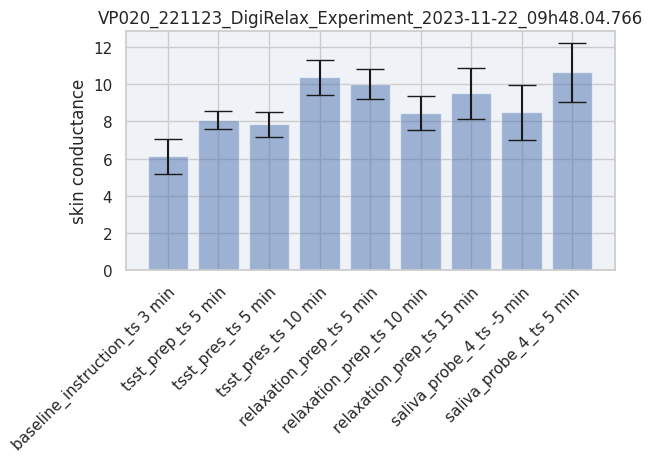

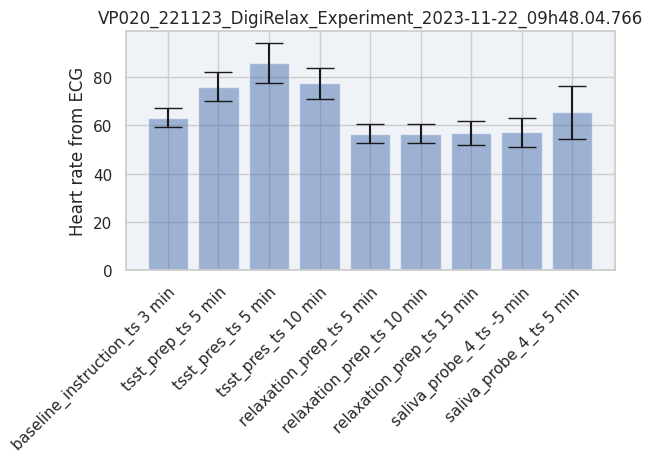

VP009_101123_DigiRelax_Experiment_2023-11-10_14h16.47.223


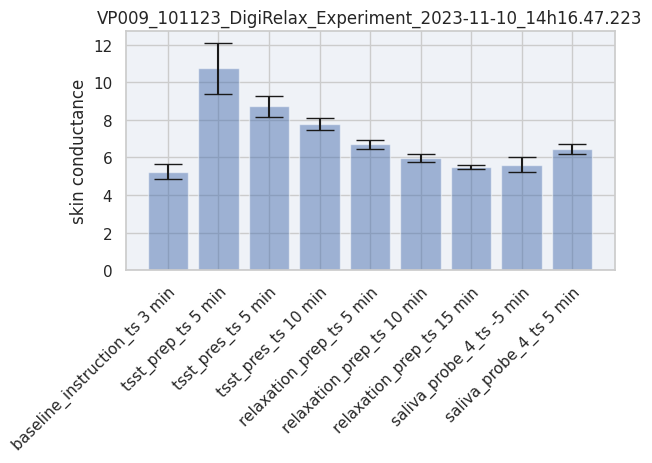

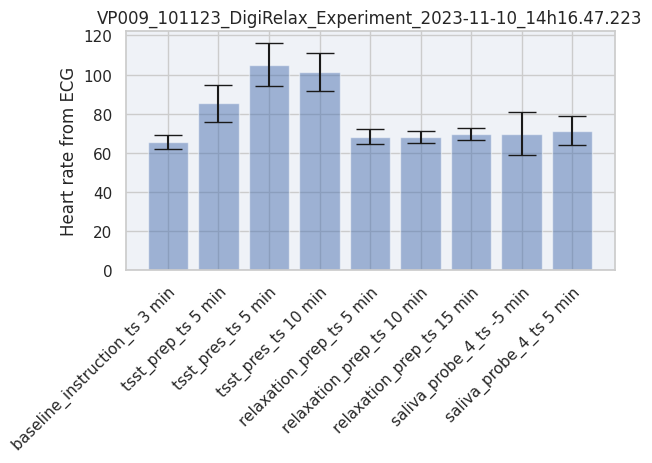

VP019_201123_DigiRelax_Experiment_2023-11-20_14h48.37.367


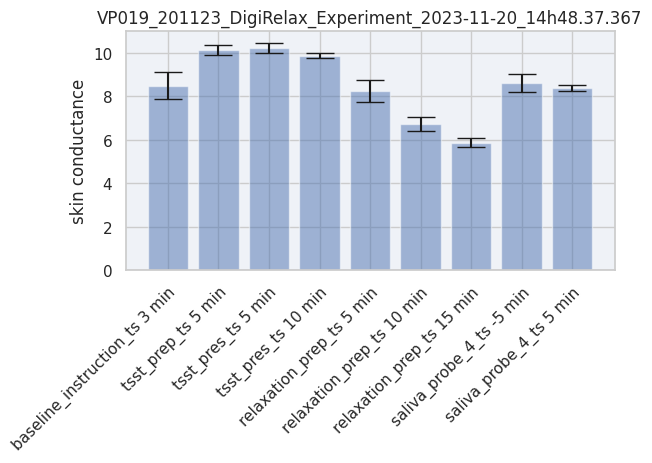

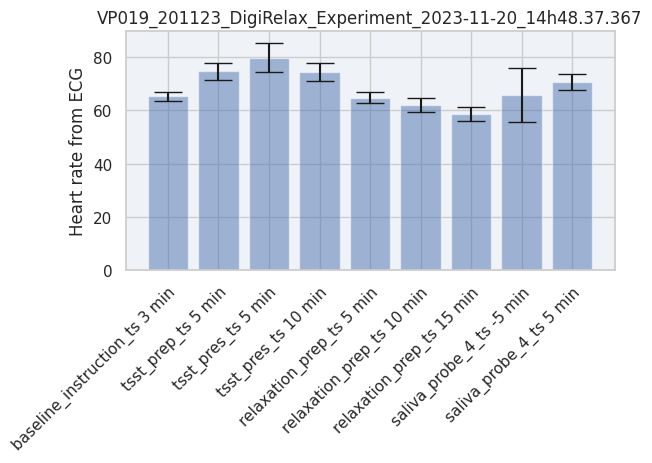

VP014_151123_DigiRelax_Experiment_2023-11-15_14h23.06.117


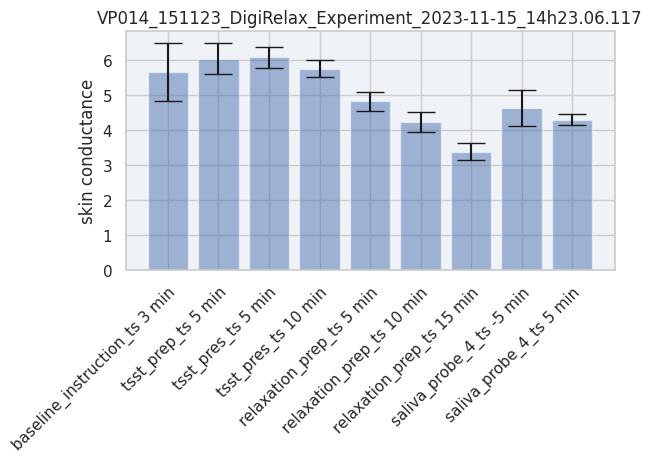

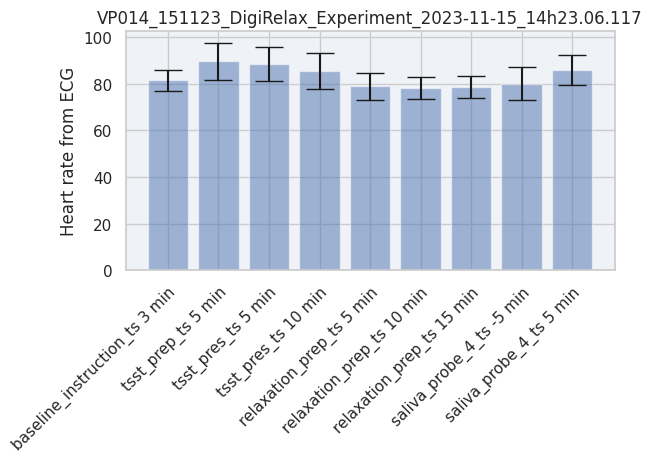

VP006_091123_DigiRelax_Experiment_2023-11-09_10h17.40.415


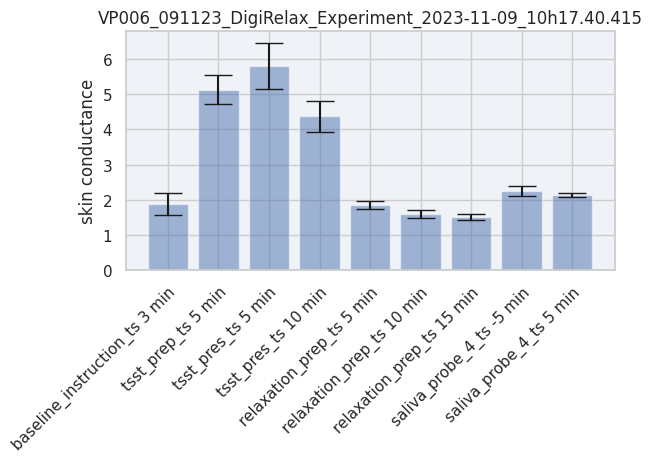

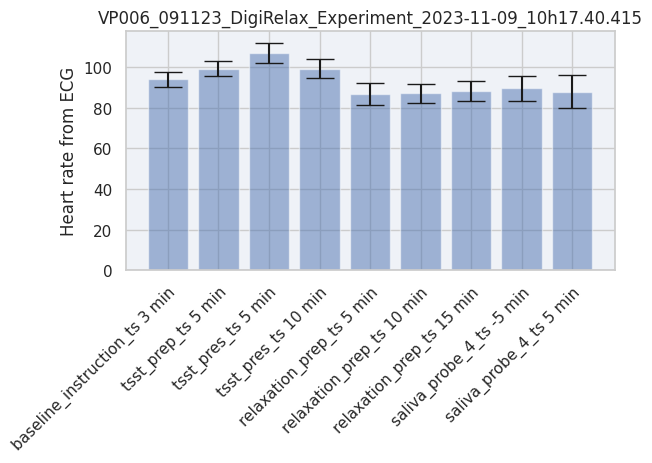

VP013_151123_DigiRelax_Experiment_2023-11-15_09h52.50.734


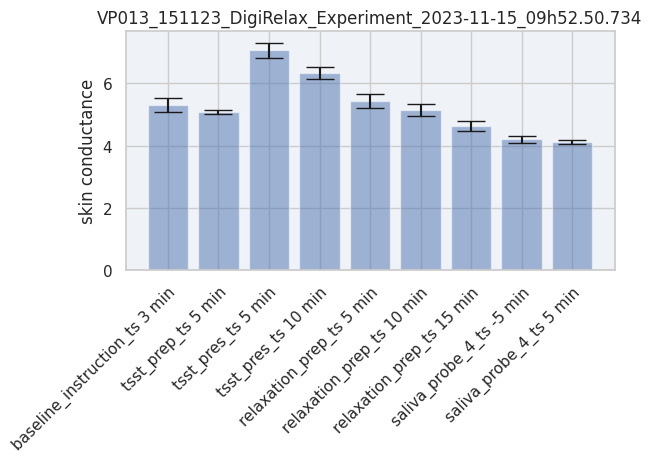

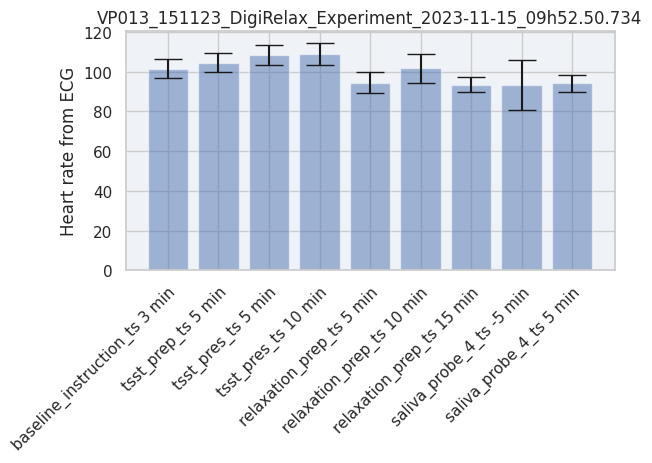

VP018_201123_DigiRelax_Experiment_2023-11-20_09h51.59.612


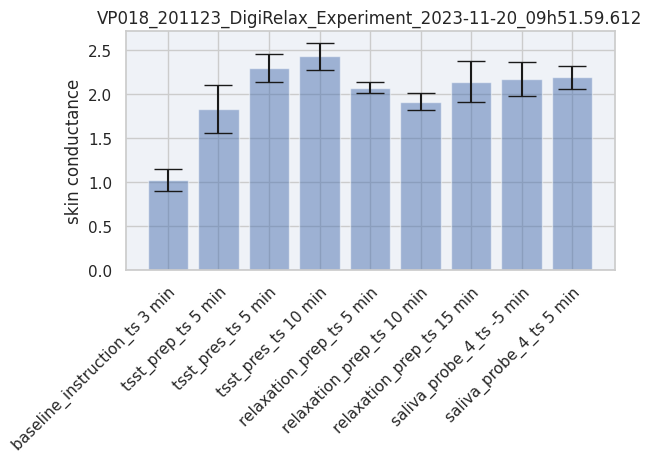

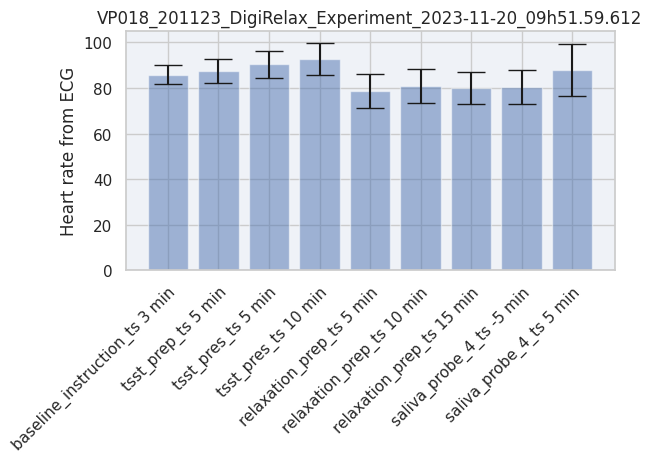

VP021_221123_DigiRelax_Experiment_2023-11-22_14h43.57.344


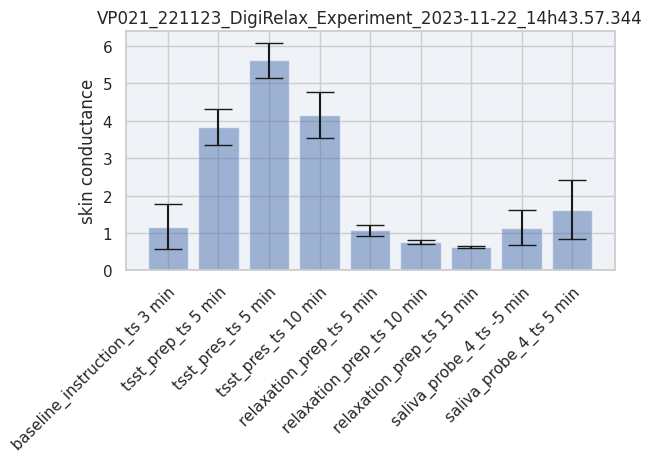

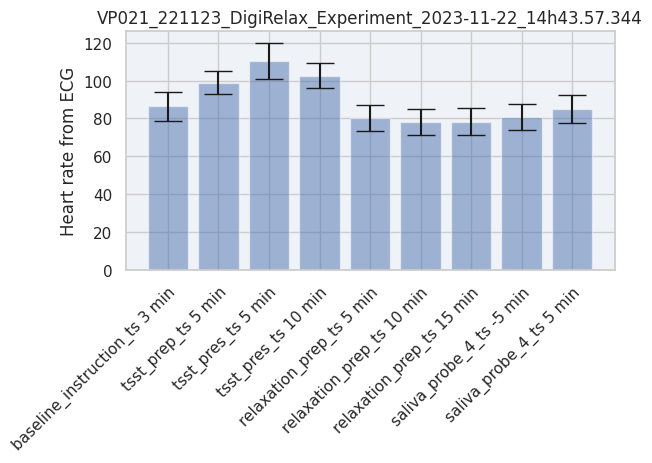

VP010_131123_DigiRelax_Experiment_2023-11-13_09h54.08.913


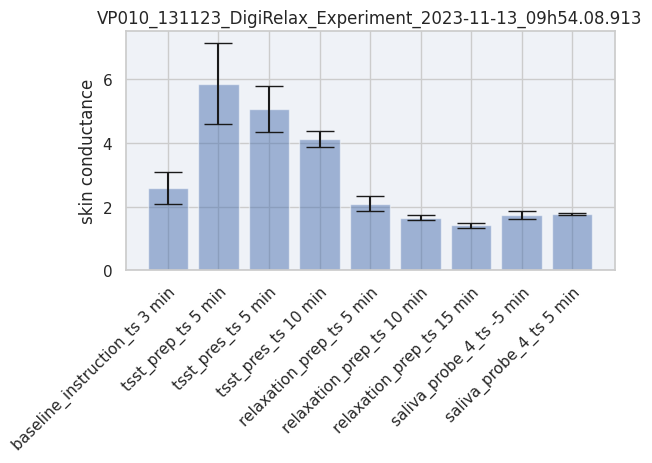

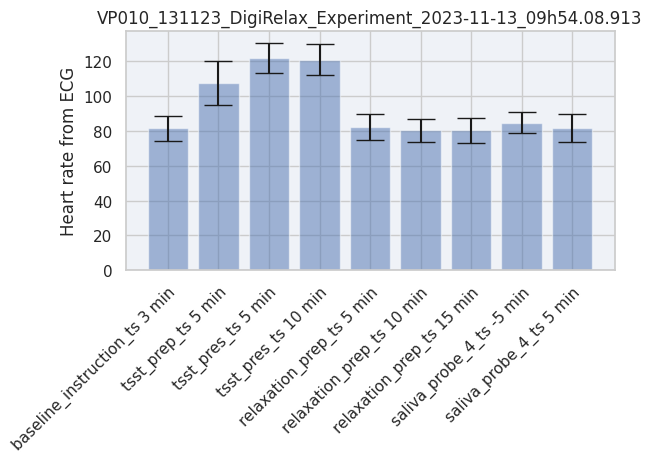

VP007_091123_DigiRelax_Experiment_2023-11-09_14h19.56.411


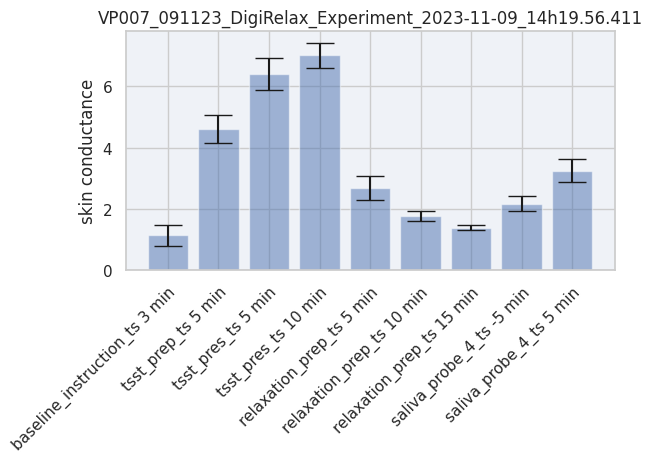

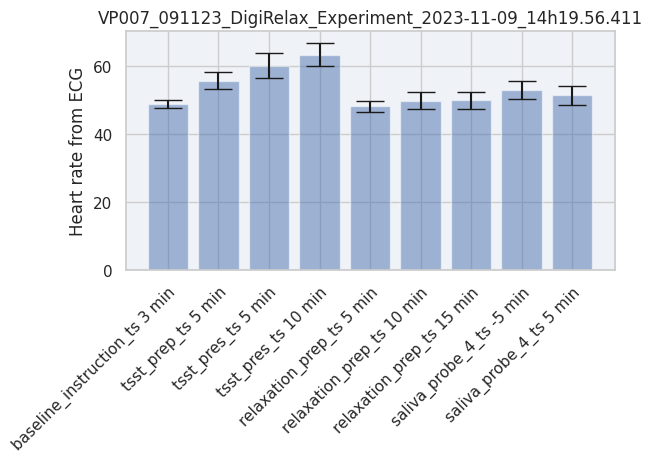

VP015_161123_DigiRelax_Experiment_2023-11-16_09h47.53.124


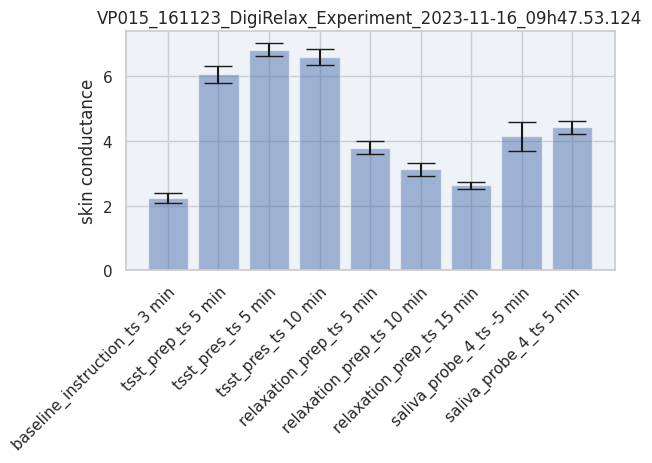

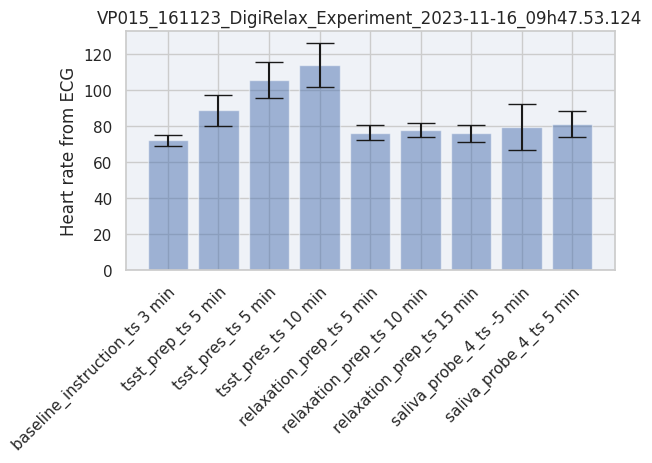

VP011_131123_DigiRelax_Experiment_2023-11-13_14h42.51.249


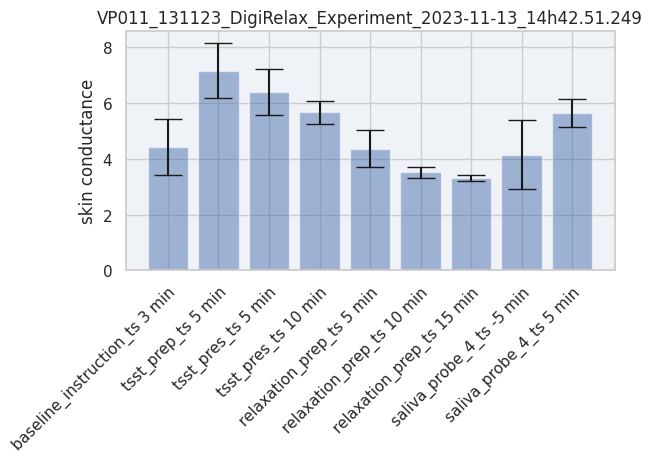

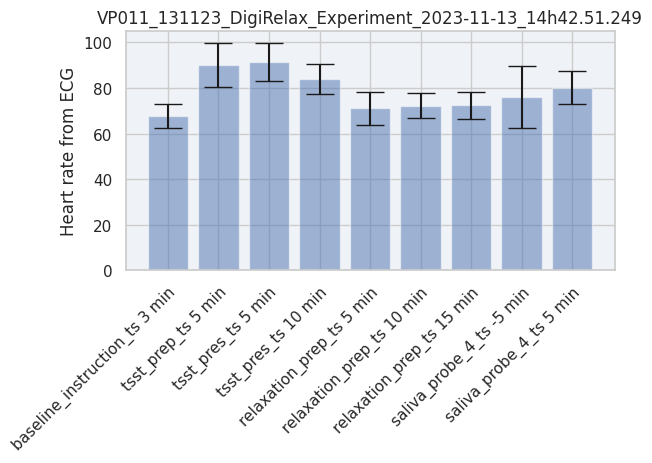

VP016_161123_DigiRelax_Experiment_2023-11-16_14h46.57.355


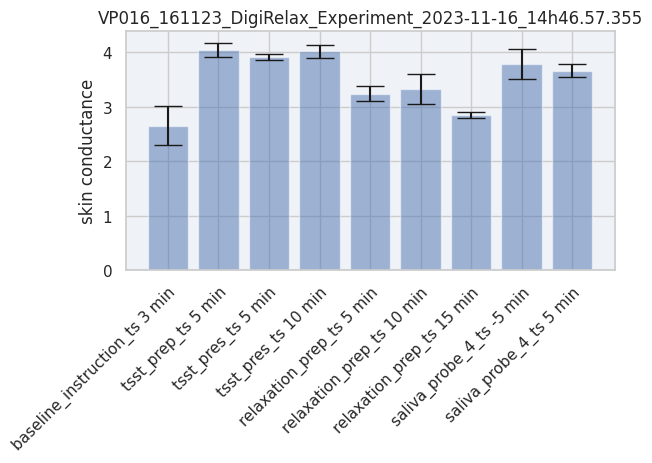

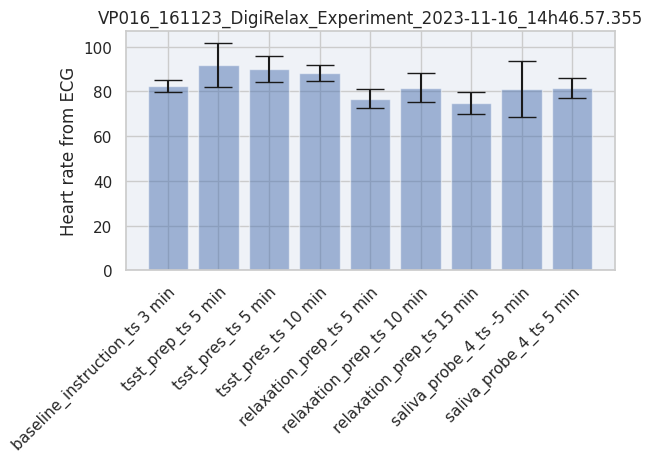

VP004_081123_DigiRelax_Experiment_2023-11-08_10h28.36.317


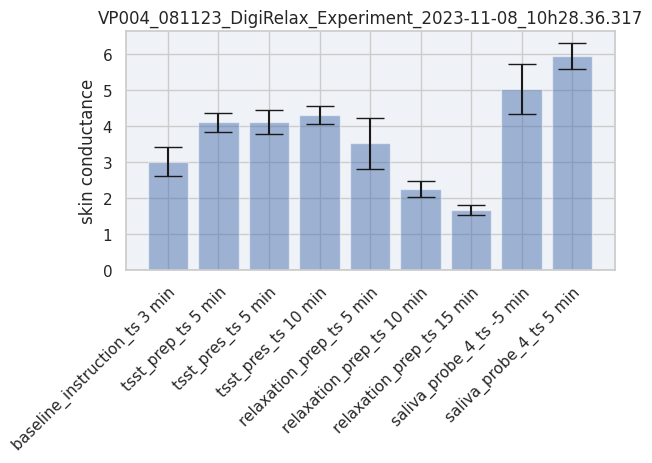

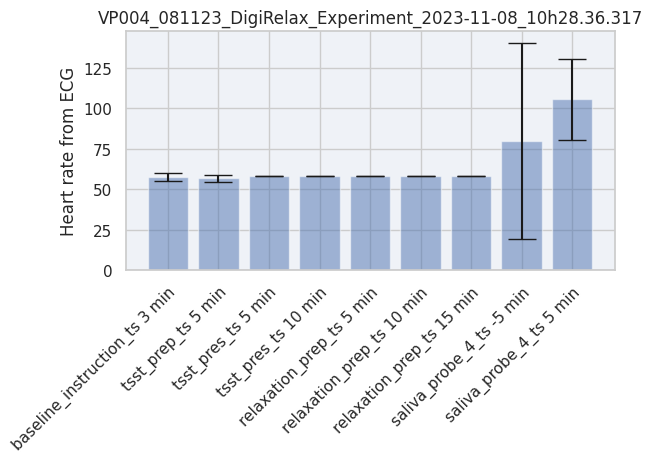

VP012_141123_DigiRelax_Experiment_2023-11-14_09h47.48.508


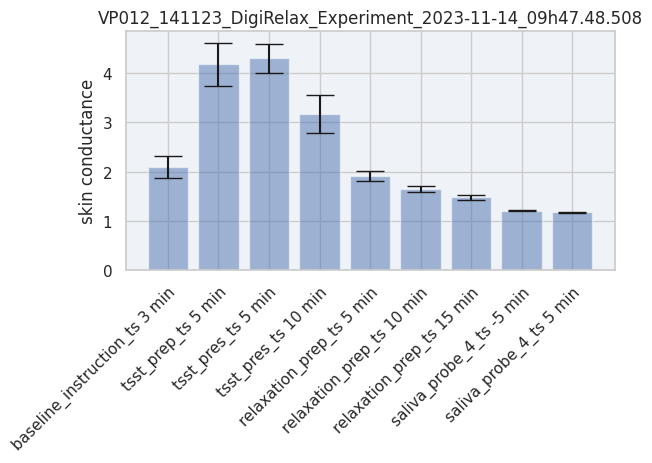

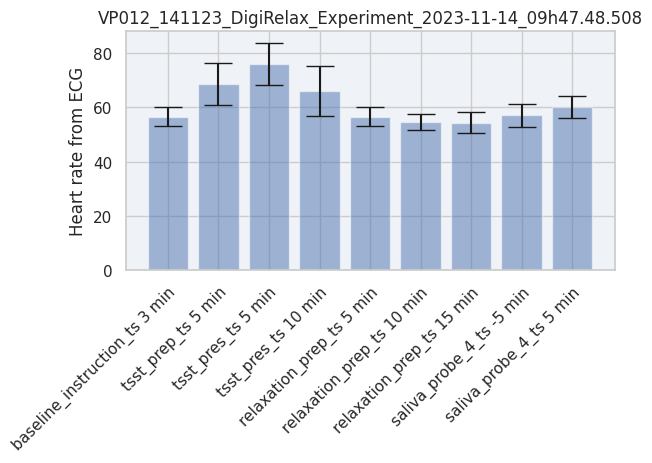

VP022_231123_DigiRelax_Experiment_2023-11-23_09h47.27.026


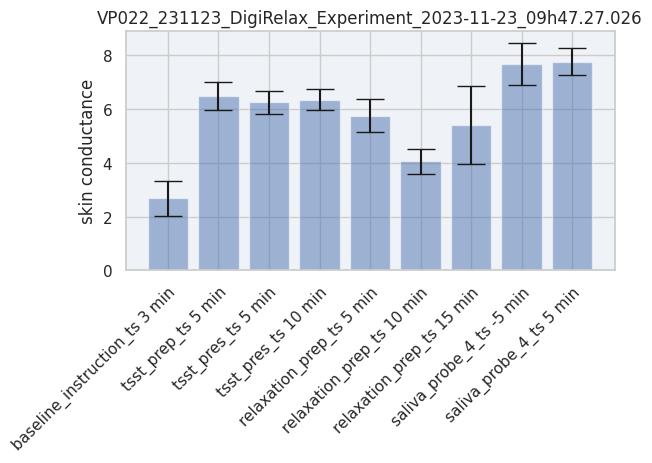

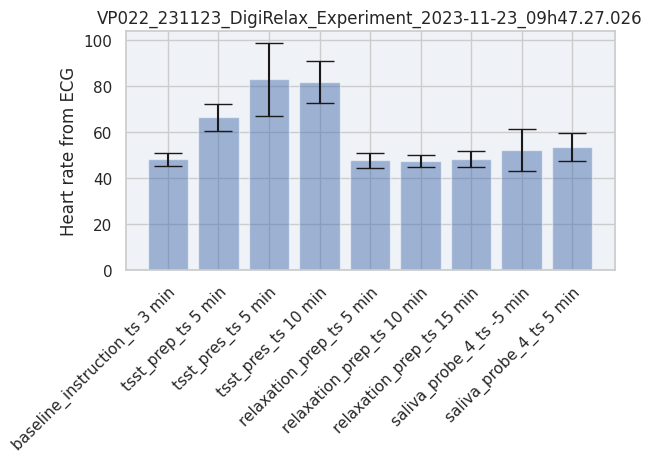

VP005_081123_DigiRelax_Experiment_2023-11-08_14h17.35.226


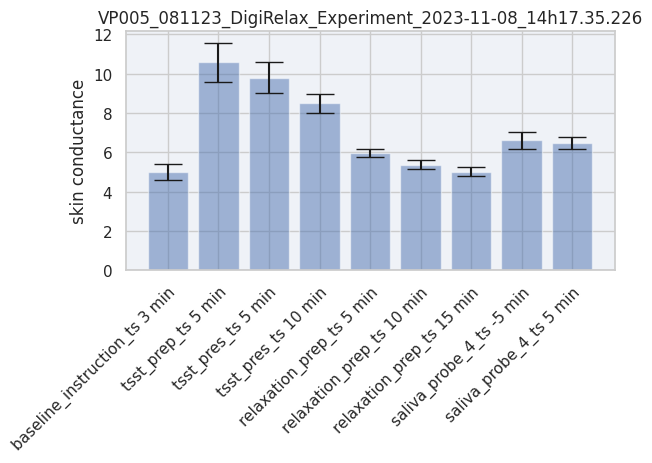

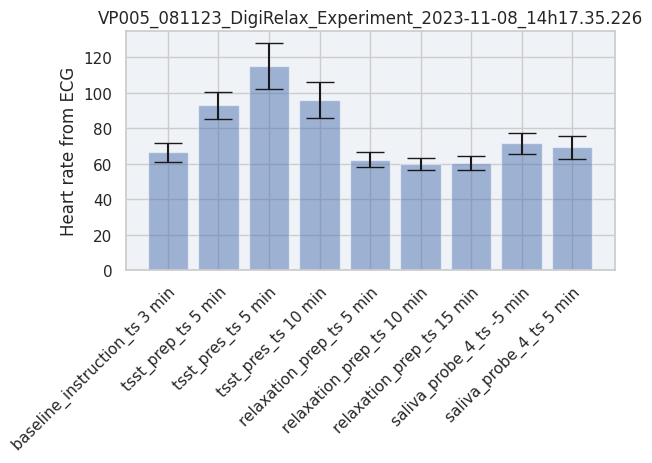

VP008_101123_DigiRelax_Experiment_2023-11-10_10h24.14.323


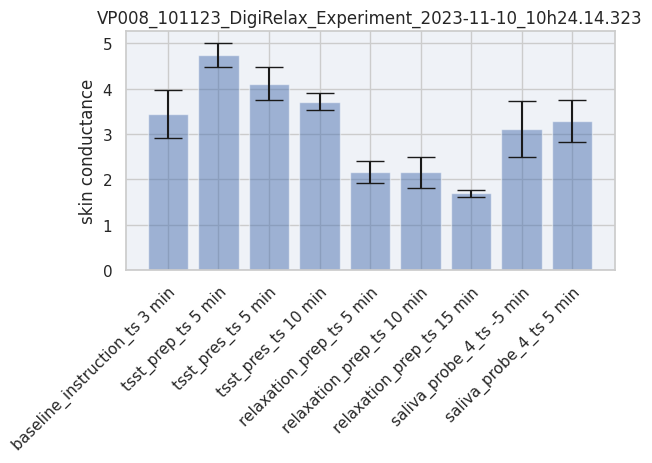

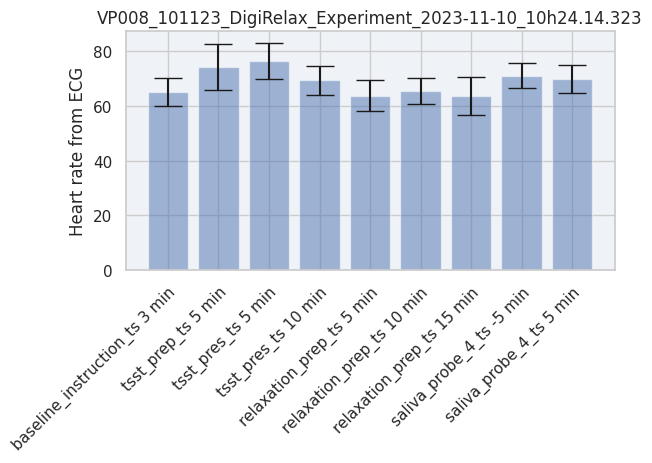

VP017_171123_DigiRelax_Experiment_2023-11-17_14h43.13.415


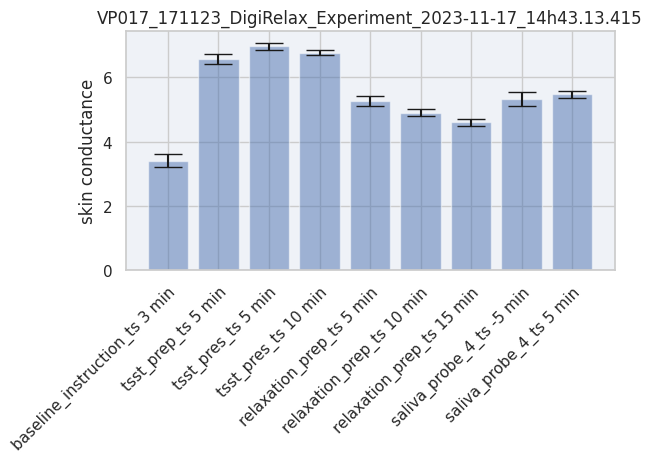

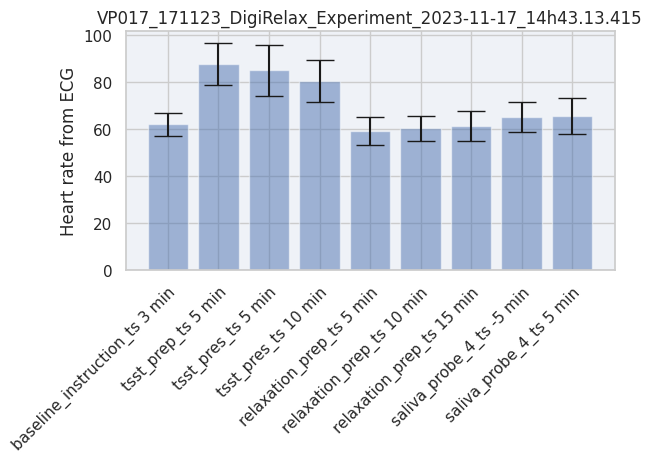

In [25]:


for sub_dir in sub_dirs:
    
    sub_dir_path= os.path.join(data_dir_path, sub_dir)
    psychopy_file_path = os.path.join(sub_dir_path, "Psychopy_data")
    psychopy_file_path = glob.glob(psychopy_file_path+ "/*.csv")[0]
    #print(psychopy_file_path)
    
    shimmer_files_subdir = os.path.join(sub_dir_path, "Shimmer_data")
    
    shimmer_files_subdir_subdir_name = next(os.walk(shimmer_files_subdir))[1][0]
    
    shimmer_files_parent_path = os.path.join(shimmer_files_subdir, shimmer_files_subdir_subdir_name)
    
    shimmer_files_name = glob.glob(shimmer_files_parent_path+ "/*.csv")
    
    for sh_file in shimmer_files_name:
        
        if '_6B1E_' in sh_file:
            hr_shimmer_path = sh_file
            
        elif "_893E_" in sh_file:
            sk_shimmer_path = sh_file
            
            
            
    fol_path, file_name=os.path.split(psychopy_file_path)
    sub_id=file_name[:-4]
    print(sub_id)
    
    ## psychop data
    psychopy_df = read_manipulate_psychopy(psychopy_file_path)
    
    
    ## Skin conductance
    timestamp_sensor_skin = "Shimmer_893E_Timestamp_Unix_CAL"
    conductance_col_name = "Shimmer_893E_GSR_Skin_Conductance_CAL"
    
    sk_cd_df=read_shimmer_sensor(sk_shimmer_path)
    sk_cd_df = standardize_timestamps_shimmer(sk_cd_df, timestamp_sensor_skin)
    sk_cd_df_selected = sk_cd_df[[timestamp_sensor_skin, conductance_col_name]]
    sk_cd_df_selected = sk_cd_df_selected.copy()
    sk_cd_df_selected=normalize_data (sk_cd_df_selected, conductance_col_name)
    
    ##for normalized data, uncomment the below_line
    
    if designated_folder == "normalized":
        conductance_col_name = "mean_norm"
    
    mean_sk_cond_list,std_sk_cond_list, x_label_plot_sk =get_mean_std_event_list(psychopy_df, sk_cd_df_selected, event_interest_list_new, offset_min_list_new, timestamp_sensor_skin, conductance_col_name)
    
    fig_sk= plot_mean_std(mean_sk_cond_list, std_sk_cond_list, x_label_plot_sk, sub_id, "skin conductance")
    
    
    
    ## heart rate
    timestamp_hr_col = "Shimmer_6B1E_Timestamp_Unix_CAL"
    hr_col_name = "Shimmer_6B1E_ECGtoHR_LL_RA_CAL"
    
    hr_df=read_shimmer_sensor(hr_shimmer_path)
    hr_df = standardize_timestamps_shimmer(hr_df, timestamp_hr_col)
    
    hr_df_selected = hr_df[[timestamp_hr_col, hr_col_name]]
    hr_df_selected = hr_df_selected.copy()
    hr_df_selected=normalize_data (hr_df_selected, hr_col_name)
    
    ##for normalized data, uncomment the below_line
    if designated_folder == "normalized":
        hr_col_name = "mean_norm"
    #hr_col_name="mean_norm"
    
    mean_hr_list,std_hr_list, x_label_plots_hr =get_mean_std_event_list(psychopy_df, hr_df_selected, event_interest_list_new, offset_min_list_new, timestamp_hr_col, hr_col_name)
    
    fig_hr=plot_mean_std(mean_hr_list, std_hr_list, x_label_plots_hr, sub_id, "Heart rate from ECG")
    
    ### Exporting data----
    
    export_dict= {"subject_id":sub_id , 'event_interst': x_label_plot_sk, "mean_sk_cond":mean_sk_cond_list , "std_sk_cond": std_sk_cond_list , "mean_hr":mean_hr_list,  "std_hr": std_hr_list}
    
    dest_path_csv = os.path.join(comp_dest_path,file_name)
    df_export = pd.DataFrame.from_dict(export_dict)
    df_export.to_csv(dest_path_csv)
    
    
    ### save skin conductance figure
    
    sk_file_name = "sk_"+sub_id +".png"
    
    dest_path_fig_sk = os.path.join(comp_dest_path,sk_file_name)
    
    fig_sk.savefig(dest_path_fig_sk)
    
    ### save heart rate figure
    
    hr_file_name = "hr_"+sub_id +".png"
    
    dest_path_fig_hr = os.path.join(comp_dest_path, hr_file_name)
    
    fig_hr.savefig(dest_path_fig_hr)
    
    
    
            
            
    
            
            
    
    
    